In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

%matplotlib inline

In [40]:
# Folders to work with for Camera Calibration & Testing the Pipeline
CAMERA_CAL = './camera_cal/'
TEST_IMGS = './test_images/'
OUTPUT_IMGS = './output_images/'

# Number of Corners in the Chessboard on the X & the Y axes
nx = 9
ny = 6

# Shape parameters of the Images we will be working with
IMG_WIDTH = 1280
IMG_HEIGHT = 720

COLOR_IMG_SHAPE = (None,720,1280,3)
GRAY_IMG_SHAPE = (None,720,1280,1)

# Choose the number of sliding windows
num_of_windows = 9

# Set height of windows
window_height = np.int(IMG_HEIGHT/num_of_windows)

# Set the width of the windows +/- margin
window_margin = 100

# Set minimum number of pixels to be found to recenter window
min_pixels_per_window = 50


In [3]:
######################### CAMERA CALIBRATION #########################

def Camera_Calibration():
    # Array to co-relate the corners found on an image to a standard X & Y axes
    objPointsCal = np.zeros((nx*ny,3), np.float32)
    objPointsCal[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store Object Points(x,y values on a standard scale) and
    # Image Points (x,y values found on the actual Chessboard Image)
    objpoints = []
    imgpoints = []

    # Iterate over all the Calibration Chessboard Images & find the Corners
    for imgs in os.listdir(CAMERA_CAL):
        # Reas the image into an array in BGR format
        img = cv2.imread(CAMERA_CAL+imgs)
        # Convert it to grayscale for use with findChessboardCorners()
        grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Obtain the Chessboard Corners
        ret, corners = cv2.findChessboardCorners(grayImg, (nx,ny), None)
        # If the function found the corners,
        if ret == True:
            # Store the points found on the image for Calibration
            imgpoints.append(corners)
            # For every image also store the x,y points for a standard grid 
            objpoints.append(objPointsCal)

    # Choose a sample image for validation
    origSampleImg = cv2.imread(CAMERA_CAL+'calibration3.jpg')
    # Convert it to grayscale to find the corners
    graySampleImg = cv2.cvtColor(origSampleImg, cv2.COLOR_BGR2GRAY)

    # Find the corners
    ret, corners = cv2.findChessboardCorners(graySampleImg, (nx,ny), None)
    # If found
    if ret == True:
        # Use the calibrateCamera the Camera and obtain:
        # mtx : Camera Matrix to convert 3D to 2D
        # dist : Distortion Co-efficicents of the Camera
        # rvecs & tvecs : Rotational and Trnaslation Vectors
        ret, camera_mtx, dist_coeff, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, graySampleImg.shape[::-1], None, None)
        
    # Undistort the test Image using the Camera Matrix and Distortion Co-efficients
    undistImg = cv2.undistort(origSampleImg, camera_mtx, dist_coeff, None, camera_mtx)

    # Create a list of Source points to perform Perspective Transformation
    src_pts = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
    # Create a list of Destination points to perform Perspective Transformation
    dst_pts = np.float32([[100.0,100.0],[1180.0,100.0],[1180.0,860.0],[100.0,860.0]])

    # Get the Perspective Transformation Matrix using the Source and Destination Points list
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    # Get the Inverse Perspective Transformation Matrix using the Destination and Source Points list
    M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    # Create a shape list to be used for Perspective Transformation
    img_shape = (undistImg.shape[1],undistImg.shape[0])
    # Perform a Perspective Transformation using the Undistorted Image, PT Matrix and Image Shape
    warpedImg = cv2.warpPerspective(undistImg, M, img_shape, flags=cv2.INTER_LINEAR)
    
    # Display the Results of the Validation
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(origSampleImg)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(warpedImg)
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return camera_mtx, dist_coeff

In [4]:
######################### IMAGE PRE-PROCESSING #########################

# Function to activate pixels of a channel in an image which fall in the threshold range
def channel_threshold(img, index=0, thresh=(0,255)):
    img = img[:,:,index]
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

# Lane Line Identifier : Function to 
# Idea for the logic to extract lane lines is inspired from : http://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
def identify_lane_lines(img):
    # Convert the image to HSV format
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # Extract the H, S and V channels of the image for a set of thresholds which highlights YELLOW Color for Yellow Lanes
    h_img = channel_threshold(hsv_img,0,(15,30))
    s_img = channel_threshold(hsv_img,1,(90,255))
    v_img = channel_threshold(hsv_img,2,(90,255))
    
    # Extract the L channel of the image which highlights the WHITE Color for White Lanes
    w_img = channel_threshold(hls_img,1,(180,255))

    # Combine the individual H,S & V channels thresholded for Yellow
    y_img = (h_img & s_img & v_img)
    
    # Combine the images which highlight the Yellow & White Lanes
    lane_img = np.zeros_like(img)
    lane_img = np.maximum(y_img,w_img)
    
    return lane_img

# Identify the points for the polygon that will ideally find the area of the image that is relevant
roi_pts = np.array([[100,IMG_HEIGHT-40],
                        [IMG_WIDTH/2-100, int(0.65*IMG_HEIGHT)],
                        [IMG_WIDTH/2+100, int(0.65*IMG_HEIGHT)],
                        [IMG_WIDTH-100, IMG_HEIGHT-40]], dtype=np.int32)
# Extract the Region of Interest : Fucntion to
def extract_roi(img):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, [roi_pts], 1)
    focus_img = cv2.bitwise_and(img, mask)
    return focus_img

# Manually chose Source and Destination points to perform Perspective Transformation
# so that we get a Bird's Eye View of the Lane Lines to identify the curvature
src_bottom_left  = [ 220, 720]
src_bottom_right = [1110, 720]
src_top_left     = [ 570, 470]
src_top_right    = [ 722, 470]
src_pts = np.float32([src_bottom_left,src_bottom_right,src_top_right,src_top_left])

dst_bottom_left = [320,720]
dst_bottom_right = [920, 720]
dst_top_left = [320, 1]
dst_top_right = [920, 1]
dst_pts = np.float32([dst_bottom_left,dst_bottom_right,dst_top_right,dst_top_left])

# Obtain the Transformation & Inverse Transformation Matrix
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
M_inv = cv2.getPerspectiveTransform(dst_pts, src_pts)

def perspective_transform(img):
    warped_img = img.copy()
    img_shape = (img.shape[1],img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_shape, flags=cv2.INTER_LINEAR)
    return warped_img

In [35]:
######################### LANE TRACKING #########################

def sliding_window_lane_tracker(binary_img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_img[int(binary_img.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    img_midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:img_midpoint])
    rightx_base = np.argmax(histogram[img_midpoint:]) + img_midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(num_of_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_img.shape[0] - (window+1)*window_height
        win_y_high = binary_img.shape[0] - window*window_height
        win_xleft_low = leftx_current - window_margin
        win_xleft_high = leftx_current + window_margin
        win_xright_low = rightx_current - window_margin
        win_xright_high = rightx_current + window_margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minimum pixels, recenter next window on their mean position
        if len(good_left_inds) > min_pixels_per_window:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > min_pixels_per_window:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    #For Testing : return out_img, left_lane_inds, right_lane_inds
    return left_lane_inds, right_lane_inds

def lane_marker(binary_img, left_lane_inds, right_lane_inds):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx

def derive_avg_line_from_history(previous_lines, new_line):
    """
        This function computes an averaged lane line by averaging over previous good frames.
    """    
    # Number of previous lines to consider
    num_of_prev_frames = 10
    
    if new_line is None:
        # No new line was detected
        if len(previous_lines) == 0:
            # And if there are no previous lines, return None
            return previous_lines, None
        else:
            # Else return the last line
            return previous_lines, previous_lines[-1]
    else:
        if len(previous_lines) < num_of_prev_frames:
            # Add new line predictions to the database
            previous_lines.append(new_line)
            return previous_lines, new_line
        else:
            # Average over the last num_of_prev_frames
            previous_lines[0:num_of_prev_frames-1] = previous_lines[1:]
            previous_lines[num_of_prev_frames-1] = new_line
            new_line = np.zeros_like(new_line)
            for i in range(num_of_prev_frames):
                new_line += previous_lines[i]
            new_line /= num_of_prev_frames
            return previous_lines, new_line
        

def measure_radius_of_curvature(x_values):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # If no pixels were found return None
    y_points = np.linspace(0, IMG_HEIGHT-1, IMG_HEIGHT)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

In [37]:
def Advanced_Lane_Tracker(img):
    # global variables to store the polynomial coefficients of the line detected in the last frame
    global polyfit_right
    global polyfit_left
    
    # global variables to store the line coordinates in previous n (=4) frames
    global past_good_right_lines
    global past_good_left_lines
    
    # global variable which contains running average of the mean difference between left and right lanes
    global running_mean_difference_between_lines
    
    img_size = (img.shape[1], img.shape[0])
    
    undist_img = cv2.undistort(img, camera_mtx, dist_coeff, None, camera_mtx)
    lane_img = identify_lane_lines(undist_img)
    roi_lane_img = extract_roi(lane_img)
    warped_img = perspective_transform(roi_lane_img)
    
    # Convert from Binary to 
    out_img = np.dstack((warped_img, warped_img, warped_img))*255
    
    non_zeros = warped_img.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]
    
    num_rows = warped_img.shape[0]
    y_points = np.linspace(0, num_rows-1, num_rows)
    
    if (polyfit_left is None) or (polyfit_right is None):
        # If the polynomial coefficients of the previous frames are None then perform a new search
        identify_new_lines = True
        left_x_pts, right_x_pts = sliding_window_lane_tracker(warped_img)
        left_x_predictions, right_x_predictions = lane_marker(warped_img, left_x_pts, right_x_pts)
    else:
        # Else search in a margin of 100 pixels on each side of the pervious polynomial fit
        identify_new_lines = False
        margin = 100
        left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
        left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

        right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
        right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]
        
        left_x_pts, right_x_pts = sliding_window_lane_tracker(warped_img)
        left_x_predictions, right_x_predictions = lane_marker(warped_img, left_x_pts, right_x_pts)
    
    if (left_x_predictions is None or right_x_predictions is None):
        if not identify_new_lines:
            left_x_pts, right_x_pts = sliding_window_lane_tracker(warped_img)
            left_x_predictions, right_x_predictions = lane_marker(warped_img, left_x_pts, right_x_pts)
            
    bad_lines = False
            
    if (left_x_predictions is None or right_x_predictions is None):
        bad_lines = True
    else:
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        
        if running_mean_difference_between_lines == 0:
            running_mean_difference_between_lines = mean_difference
        
        if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
            bad_lines = True
            if not identify_new_lines:
                left_x_pts, right_x_pts = sliding_window_lane_tracker(warped_img)
                left_x_predictions, right_x_predictions = lane_marker(warped_img, left_x_pts, right_x_pts)
                if (left_x_predictions is None or right_x_predictions is None):
                    bad_lines = True
                else:
                    mean_difference = np.mean(right_x_predictions - left_x_predictions)
                    if (mean_difference < 0.7*running_mean_difference_between_lines or mean_difference > 1.3*running_mean_difference_between_lines):
                        bad_lines = True
                    else:
                        bad_lines = False
        else:
            bad_lines = False
            
    if bad_lines:
        polyfit_left = None
        polyfit_right = None
        if len(past_good_left_lines) == 0 and len(past_good_right_lines) == 0:
            return img
        else:
            left_x_predictions = past_good_left_lines[-1]
            right_x_predictions = past_good_right_lines[-1]
    else:
        past_good_left_lines, left_x_predictions = derive_avg_line_from_history(past_good_left_lines, left_x_predictions)
        past_good_right_lines, right_x_predictions = derive_avg_line_from_history(past_good_right_lines, right_x_predictions)
        mean_difference = np.mean(right_x_predictions - left_x_predictions)
        running_mean_difference_between_lines = 0.9*running_mean_difference_between_lines + 0.1*mean_difference
    
    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))
    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))
    
    # compute the radius of curvature
    left_curve_rad = measure_radius_of_curvature(left_x_predictions)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    
    # compute the offset from the center
    lane_center = (right_x_predictions[num_rows-1] + left_x_predictions[num_rows-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    
    poly_points = np.vstack([left_line_window, right_line_window])
    
    cv2.fillPoly(out_img, np.int_([poly_points]), [0,255, 0])
    
    unwarped_img = cv2.warpPerspective(out_img, M_inv, img_size , flags=cv2.INTER_LINEAR)

    result = cv2.addWeighted(img, 1, unwarped_img, 0.3, 0)
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

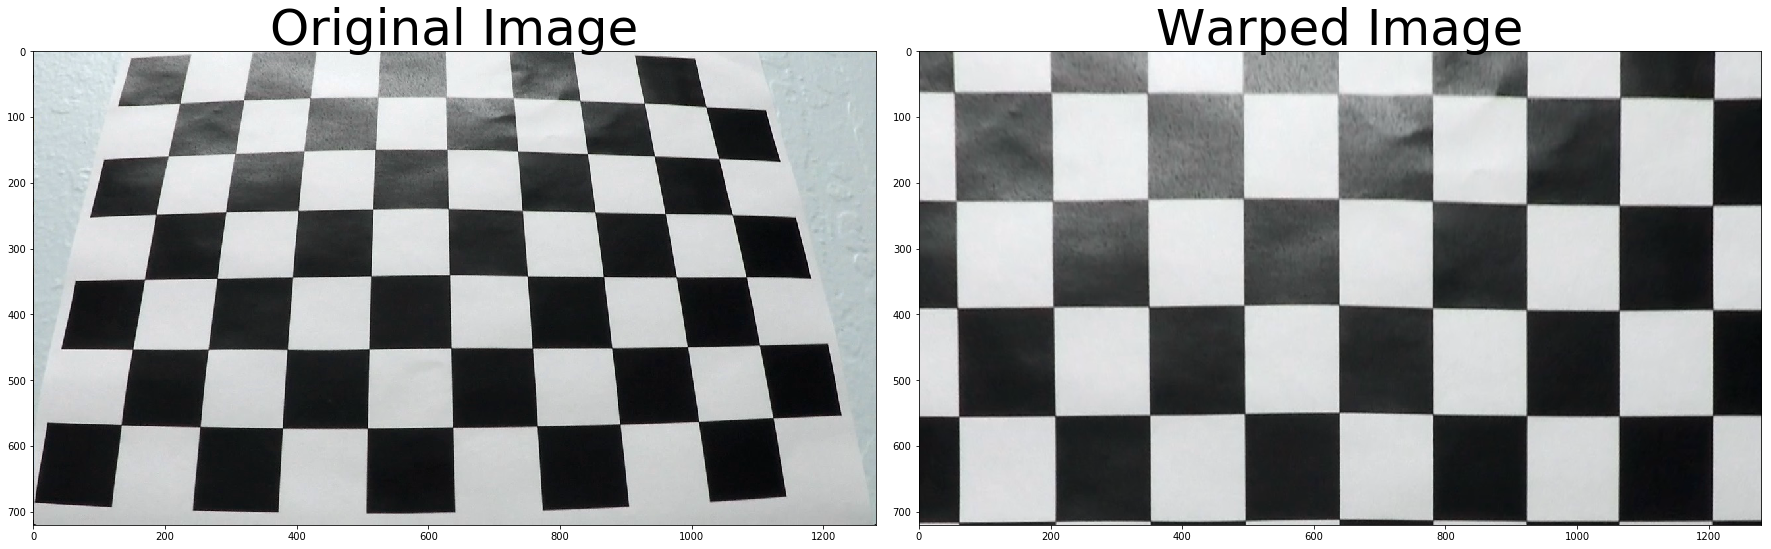

In [7]:
camera_mtx, dist_coeff = Camera_Calibration()

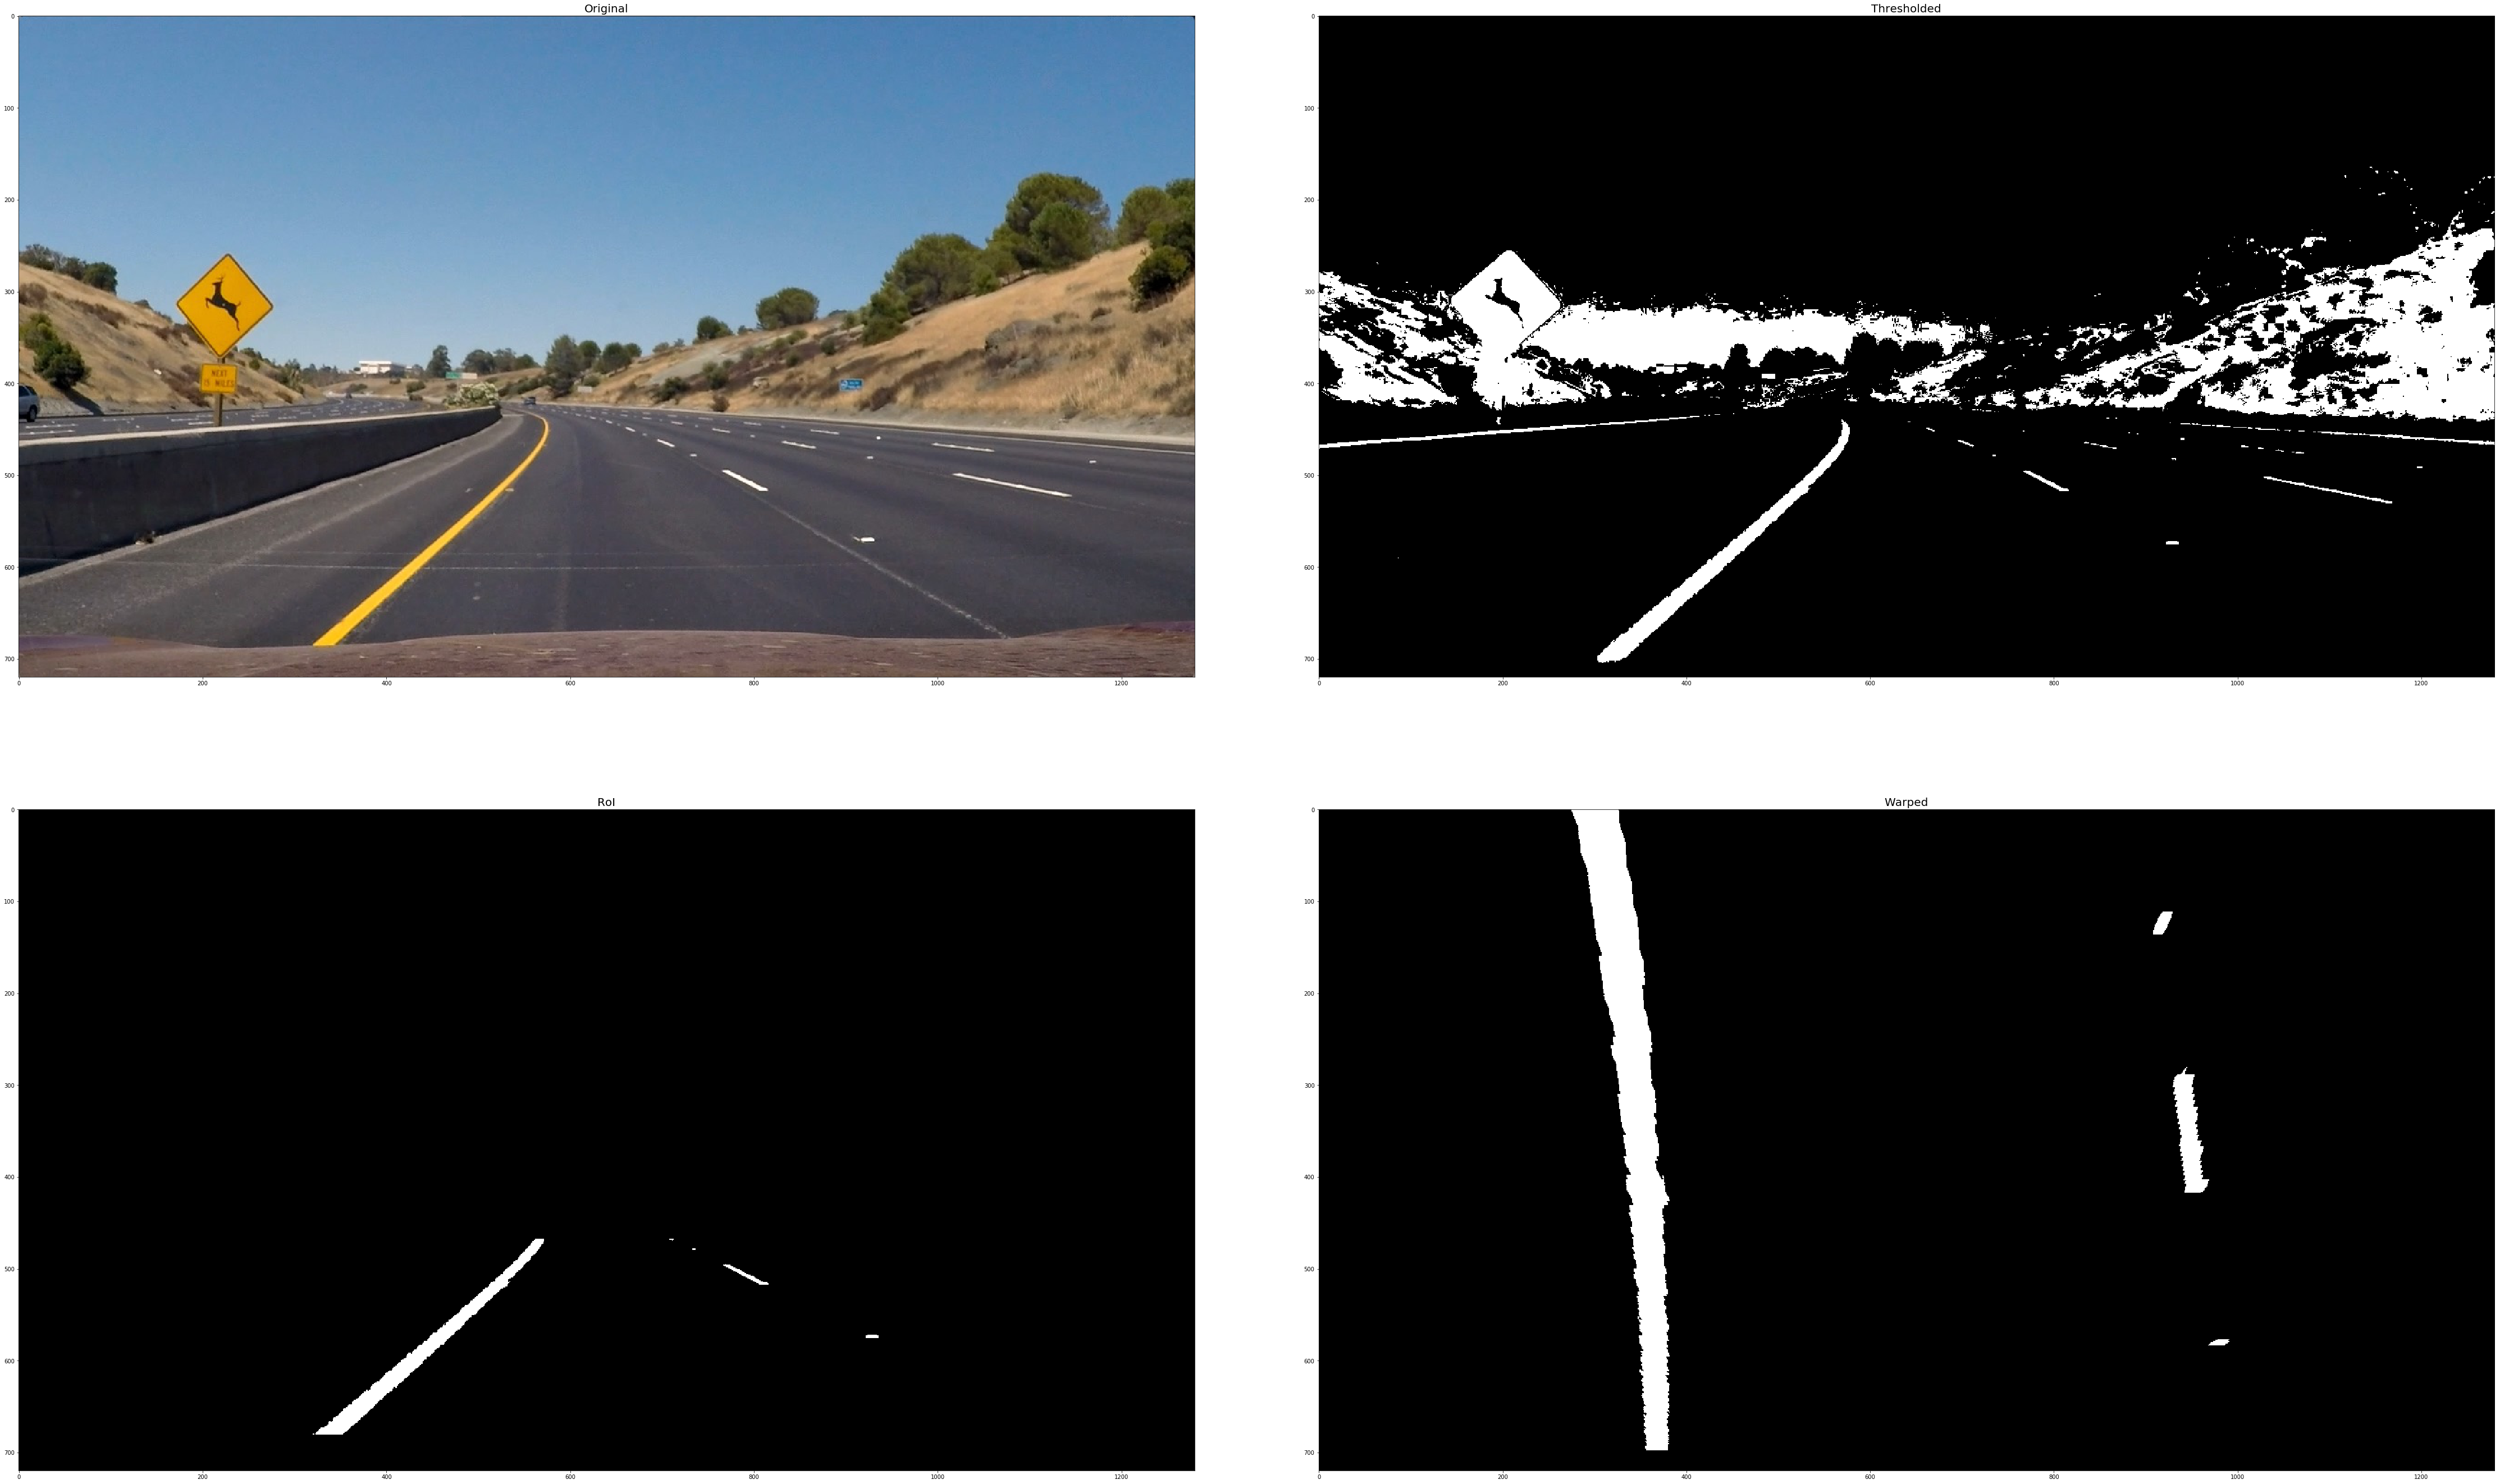

In [30]:
######################### PIPELINE VALIDATION #########################

# Test the Image Pre-processing Pipeline
f, axes = plt.subplots(2, 2, figsize=(64, 36))
axes = axes.ravel()
f.tight_layout()

# Pick a sample test images for testing the pipeline
raw_test_img = mpimg.imread('test_images/test2.jpg')
undist_test_img = cv2.undistort(raw_test_img, camera_mtx, dist_coeff, None, camera_mtx)
lane_test_img = identify_lane_lines(undist_test_img)
roi_test_img = extract_roi(lane_test_img)
warped_test_img = perspective_transform(roi_test_img)

axes[0].imshow(raw_test_img)
axes[0].set_title('Original', fontsize=20)
axes[1].imshow(lane_test_img, cmap='gray')
axes[1].set_title('Thresholded', fontsize=20)
axes[2].imshow(roi_test_img, cmap='gray')
axes[2].set_title('RoI', fontsize=20)
axes[3].imshow(warped_test_img, cmap='gray')
axes[3].set_title('Warped', fontsize=20) 
    
plt.subplots_adjust(left=0.0, right=1.0, top=2.0, bottom=1.0, wspace=0.01, hspace=0.2)    

(720, 0)

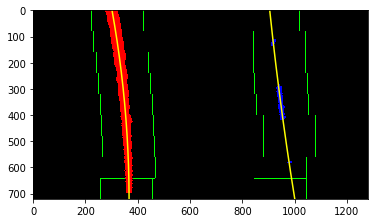

In [33]:
# Create an image to draw on and an image to show the selection window
#out_img = np.dstack((warped_test_img, warped_test_img, warped_test_img))*255

non_zeros = warped_test_img.nonzero()
non_zeros_y = non_zeros[0]
non_zeros_x = non_zeros[1]

out_img, left_coordinates, right_coordinates = sliding_window_lane_tracker(warped_test_img)

out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

left_x_predictions, right_x_predictions = lane_marker(warped_test_img, left_coordinates, right_coordinates)

y_points = np.linspace(0, IMG_HEIGHT-1, IMG_HEIGHT)

plt.imshow(out_img)
plt.plot(left_x_predictions, y_points, color='yellow')
plt.plot(right_x_predictions, y_points, color='yellow')
plt.xlim(0, warped_test_img.shape[1])
plt.ylim(warped_test_img.shape[0],0)

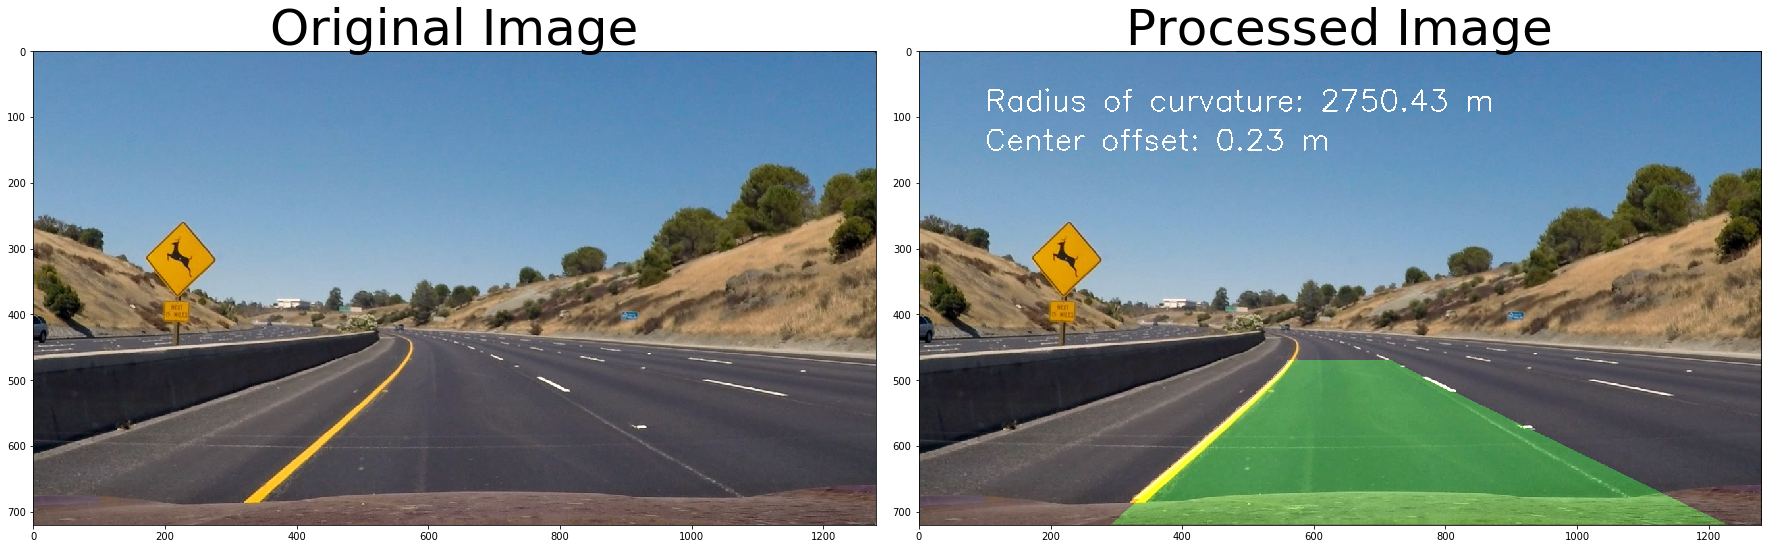

In [38]:
# Test the Image Pre-processing Pipeline
img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = Advanced_Lane_Tracker(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [44]:
# Generate Output Images for Test Images

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

for imgs in os.listdir(TEST_IMGS):
    rawtestImg = mpimg.imread(TEST_IMGS+imgs)
    rawtestImg = cv2.undistort(rawtestImg, camera_mtx, dist_coeff, None, camera_mtx)
    
    # Apply pipeline
    processed = Advanced_Lane_Tracker(rawtestImg)
    
    cv2.imwrite(OUTPUT_IMGS+imgs, processed)
    

In [39]:
from moviepy.editor import VideoFileClip

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(Advanced_Lane_Tracker) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [02:28<00:00,  8.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 2min 29s
